# Adaptive step size ODE filters


In `probnum`, we implement the step size adaptation scheme from Schober et al., 2019:

https://arxiv.org/pdf/1610.05261.pdf

We show how for the KF-IBM(1) Combo, they work very well (which is what they write in their paper) but also, how it doesn't quite generalise to other filters.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from probnum.diffeq import lotkavolterra, filter_ivp, filter_ivp_h
from probnum.prob import RandomVariable, Normal, Dirac


### IBM(1) with KF

We start by showing how solving an IVP with adaptive steps works:

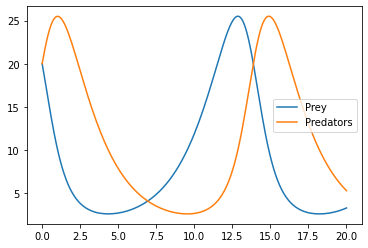

In [3]:
initrv = RandomVariable(distribution=Dirac(np.array([20, 20])))
ivp = lotkavolterra([0., 20.], initrv)
ms, cs, ts = filter_ivp(ivp, tol=1e-1)
ms1, cs1 = ms[:, 0], cs[:, 0, 0]
ms2, cs2 = ms[:, 2], cs[:, 2, 2]

plt.plot(ts, ms1, label="Prey")
plt.plot(ts, ms2, label="Predators")
plt.legend()
plt.show()

Now lets repeat the previous plot, but this time we visualise the steps:

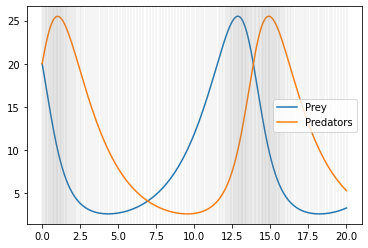

In [4]:
initrv = RandomVariable(distribution=Dirac(np.array([20, 20])))
ivp = lotkavolterra([0., 20.], initrv)
ms, cs, ts = filter_ivp(ivp, tol=1e-1, which_prior="ibm1")
ms1, cs1 = ms[:, 0], cs[:, 0, 0]
ms2, cs2 = ms[:, 2], cs[:, 2, 2]

plt.plot(ts, ms1, label="Prey")
plt.plot(ts, ms2, label="Predators")
for t in ts:
    plt.axvline(t, linewidth=0.15, color="gray")
plt.legend()
plt.show()

Note how more steps are taken at the inclines than at the declines. 

## Adaptive steps in a very noisy setting and q=2 priors

We investigate how different priors and different filters fare, wenn the ODE is corrupted. That is, we add $R=0.5$ to the measurement model at each step.

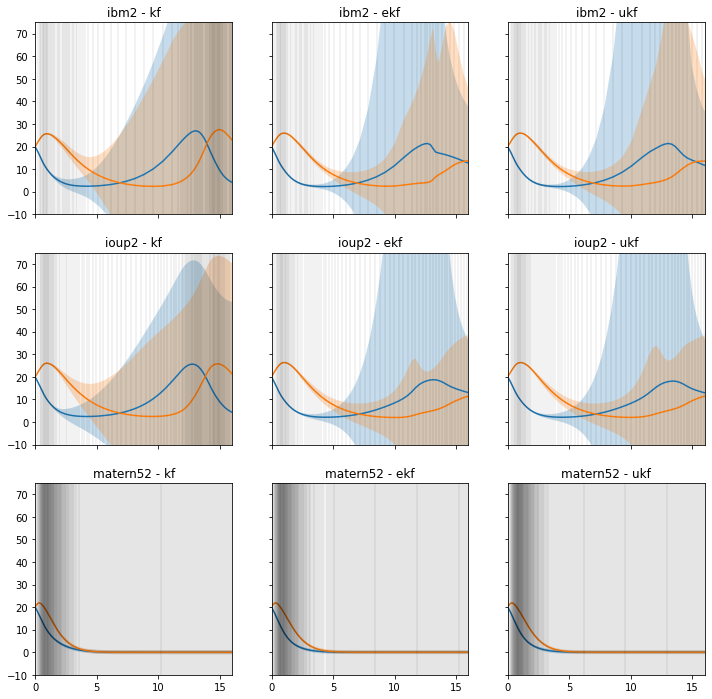

In [24]:
priors = ["ibm2", "ioup2", "matern52"]
filters = ["kf", "ekf", "ukf"]

initrv = RandomVariable(distribution=Dirac(np.array([20, 20])))
t0, tmax = 0., 16
ivp = lotkavolterra([t0, tmax], initrv)

fig, ax = plt.subplots(nrows=len(priors), ncols=len(filters), sharex=True, sharey=True, figsize=(12, 12))

for idx in range(len(priors)):   # priors in rows
    for jdx in range(len(filters)):  # filters in cols
        ms, cs, ts = filter_ivp(ivp, tol=0.25, firststep=None, evlvar=5e-1, 
                                which_prior=priors[idx], which_filt=filters[jdx])
        ms1, cs1 = ms[:, 0], cs[:, 0, 0]
        ms2, cs2 = ms[:, 3], cs[:, 3, 3]
        ax[idx][jdx].plot(ts, ms1)
        ax[idx][jdx].fill_between(ts, ms1-3*cs1, ms1+3*cs1, alpha=0.25)
        ax[idx][jdx].plot(ts, ms2)
        ax[idx][jdx].fill_between(ts, ms2-3*cs2, ms2+3*cs2, alpha=0.25)
        for t in ts:
            ax[idx][jdx].axvline(t, linewidth=0.1, color="black")
        ax[idx][jdx].set_title(priors[idx] + " - " + filters[jdx])
        ax[idx][jdx].set_xlim((t0, tmax))
        ax[idx][jdx].set_ylim((-10, 75))
        ax[idx][jdx].set_title(priors[idx] + " - " + filters[jdx])
plt.show()

Note how the Matern prior goes to sleep straightaway. The IOUP and IBM priors seem to retract some sort of periodicity, especially with the KF method. EKF and UKF are doing really badly, but at least their uncertainty explodes which is something. 

It seems that IOUP implies more steps than IBM and that Matern implies many more steps. This is probably due to the different whitenings in error estimation: the innovation term is much smaller for Matern and IOUP, hence the error estimate is increased compared to the IBM. It is not clear what the better choice is between IBM and IOUP, howeveer, it is evident that the innovation term for Matern is a bit overconfident.

## The same, in a "nicer" setting

Here, nicer means: a lot less evaluation varianc (1e-6 instead of 1e0). This is a well-posed problem and as such, should be solved well with the adaptive step sizes. 

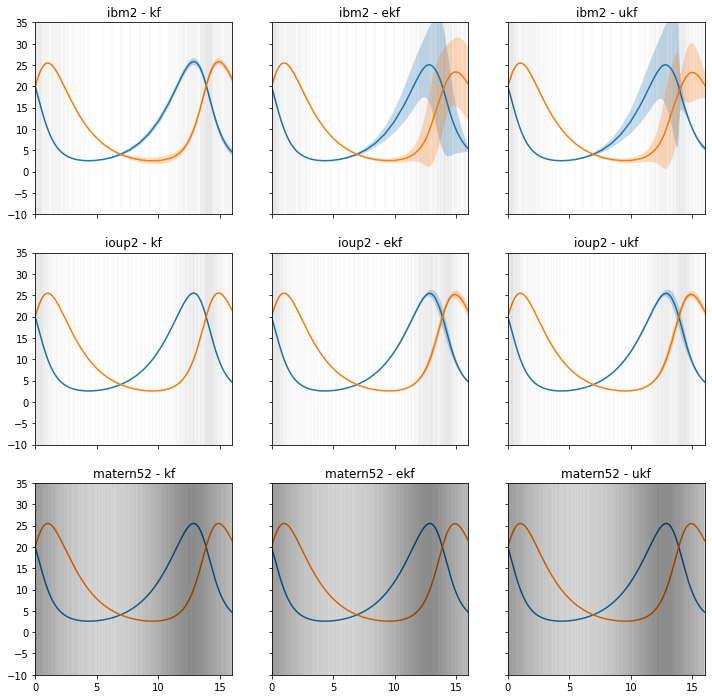

In [22]:
priors = ["ibm2", "ioup2", "matern52"]
filters = ["kf", "ekf", "ukf"]

initrv = RandomVariable(distribution=Dirac(np.array([20, 20])))
t0, tmax = 0., 16
ivp = lotkavolterra([t0, tmax], initrv)

fig, ax = plt.subplots(nrows=len(priors), ncols=len(filters), sharex=True, sharey=True, figsize=(12, 12))

for idx in range(len(priors)):   # priors in rows
    for jdx in range(len(filters)):  # filters in cols
        ms, cs, ts = filter_ivp(ivp, tol=0.25, firststep=None, evlvar=1e-06,
                                which_prior=priors[idx], which_filt=filters[jdx])
        ms1, cs1 = ms[:, 0], cs[:, 0, 0]
        ms2, cs2 = ms[:, 3], cs[:, 3, 3]
        ax[idx][jdx].plot(ts, ms1)
        ax[idx][jdx].fill_between(ts, ms1-30*cs1, ms1+30*cs1, alpha=0.25)
        ax[idx][jdx].plot(ts, ms2)
        ax[idx][jdx].fill_between(ts, ms2-30*cs2, ms2+30*cs2, alpha=0.25)
        for t in ts:
            ax[idx][jdx].axvline(t, linewidth=0.05, color="black")
        ax[idx][jdx].set_title(priors[idx] + " - " + filters[jdx])
        ax[idx][jdx].set_xlim((t0, tmax))
        ax[idx][jdx].set_ylim((-10, 35))
        ax[idx][jdx].set_title(priors[idx] + " - " + filters[jdx])
plt.show()

They all seem to catch the true solution. Note again how the Matern prior again takes (probably way) too many steps. But at least it catches the true solution. EKF and UKF seem unstable, but using them in conjunction with IOUP seems to lessen the problem. At least for IBM their uncertainties are very larte at the right places, which is something. In general it seems that IOUP fits a bit better for Lotka-Volterra equations but that is a rather vague statement and needs more investigation. 

## Could it have been the hyperparameters?


It seems that the "too many steps" phenomena were due to poor hyperparameter choices. 

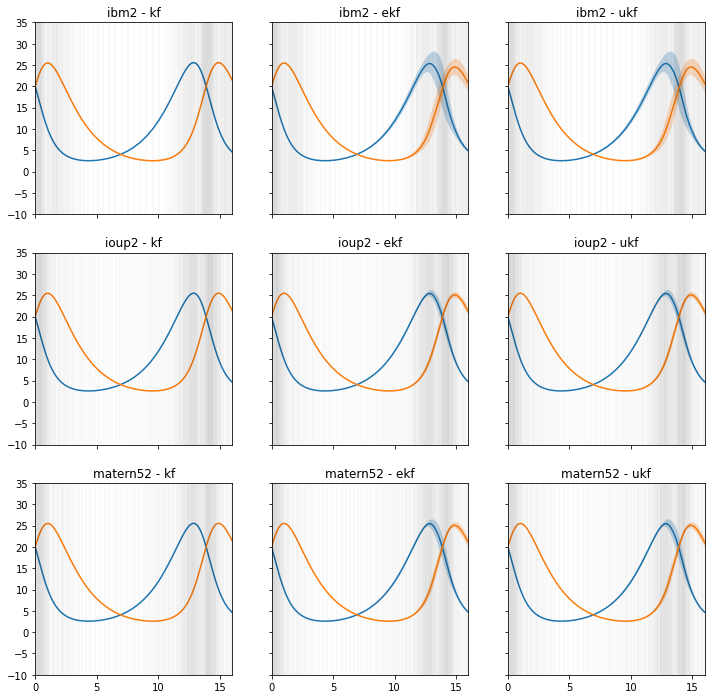

In [21]:
priors = ["ibm2", "ioup2", "matern52"]
filters = ["kf", "ekf", "ukf"]

initrv = RandomVariable(distribution=Dirac(np.array([20, 20])))
t0, tmax = 0., 16
ivp = lotkavolterra([t0, tmax], initrv)

fig, ax = plt.subplots(nrows=len(priors), ncols=len(filters), sharex=True, sharey=True, figsize=(12, 12))

for idx in range(len(priors)):   # priors in rows
    for jdx in range(len(filters)):  # filters in cols
        ms, cs, ts = filter_ivp(ivp, tol=0.125, firststep=None, evlvar=1e-04, lengthscale=8,
                                which_prior=priors[idx], which_filt=filters[jdx])
        ms1, cs1 = ms[:, 0], cs[:, 0, 0]
        ms2, cs2 = ms[:, 3], cs[:, 3, 3]
        ax[idx][jdx].plot(ts, ms1)
        ax[idx][jdx].fill_between(ts, ms1-30*cs1, ms1+30*cs1, alpha=0.25)
        ax[idx][jdx].plot(ts, ms2)
        ax[idx][jdx].fill_between(ts, ms2-30*cs2, ms2+30*cs2, alpha=0.25)
        for t in ts:
            ax[idx][jdx].axvline(t, linewidth=0.05, color="black")
        ax[idx][jdx].set_title(priors[idx] + " - " + filters[jdx])
        ax[idx][jdx].set_xlim((t0, tmax))
        ax[idx][jdx].set_ylim((-10, 35))
        ax[idx][jdx].set_title(priors[idx] + " - " + filters[jdx])
plt.show()

Unfortunately we have to adjust the evaluation variance in order to guarantee positive definiteness of the innovation term.

The IBM prior essentially has no hyperparameters (except for the diffusion constant which gets calibrated in the end and is only responsible for the uncertainty estimates). Matern and IOUP however depend on length scale and drift speed, for example. If the lengthscale is increased from $1$ to $10$, the Matern solution roughly takes as many steps as the IBM prior. 

This also makes the Matern solution do much better on the noisy setting.

The problem here is that in order to calibrate these hyperparameters in advance we cannot rely on usual GP tuning methods as the data is not available. It seems that setting it to lengthscale = 1/tol does a decent job, however, that is not theoretically sound at all.

## Future Work

It seems to me that a necessary, but also very promising line of work is in hyperparameter tuning for IOUP and Matern priors. If this does well, that opens a lot of doors for reliable usage of these filters in interesting settings.

It might also be interesting to think more about the relative error/absolute error relation. Of course, this goes hand in hand with the previous point (better hyperparameters give better error estimates which give more reasonable steps) but is an interesting and important question on its own.